In [1]:
import torch
print(torch.__version__)

2.1.0+cu121


In [2]:
!nvidia-smi

Sun Jan 14 18:51:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Pytorch 2.0 syntax

torch.multiprocessing.set_start_method('spawn', force=True)

import torchvision

model = torchvision.models.resnet50()
compiled_model = torch.compile(model) # new torch2.0 feature

##Pytorch 2.0 features work best on newer NVIDIA GPUs.

To see if your GPU is compatible see NVIDIA GPU compatibility scores. If your GPU has a score of 8.0+, it can leverage most if not all Pytorch 2.0 features

GPUs under 8.0 can still leverage PyTorch 2.0, however, the improvements may not be as noticeable as those with 8.0+

In [4]:
from math import e
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  #Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available")
  else:
    print(f"GPU score lower than (8,0), PyTorch 2.x speedup features will be limited")

  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0")

GPU name: Tesla_T4
GPU capability score: (7, 5)
GPU score lower than (8,0), PyTorch 2.x speedup features will be limited
GPU information:
Sun Jan 14 18:52:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                   

In [5]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
generator = torch.Generator('cuda')


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


### 1.1 Globally set devices

Previously we've set the devices using the `.to(device)`

In PyTorch 2.0 is possible to set the device with a context manager as a global device.

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Set the device with context manager (requires Pytorch 2.x+)
with torch.device(device):
  #All tensors or PyTorch objects created in the context manager will be on the target device
  layer = torch.nn.Linear(20, 30)
  print(f"Layer weights are on device: {layer.weight.device}")
  print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")


Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


In [7]:
#In order to set the device globally

torch.set_default_device(device)

layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

model = torchvision.models.resnet50()
compiled_model = torch.compile(model) # new torch2.0 feature

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


## 2. Setting up the experiments, time to test speed

Time to test speed!

To keep things simple, we'll run 4 experiments:

* Model: ResNet50 fromm torchvision
* Data: CIFAR10 from torchvision
* Epochs: 5 (single run) and 3x5 (multiple runs)
* Batch size: 128
* Image size: 224

In [8]:
model_weights = torchvision.models.ResNet50_Weights.DEFAULT
transforms = model_weights.transforms

transforms

functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=224, resize_size=232)

In [9]:
model  = torchvision.models.resnet50(weights=model_weights)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
total_params = sum(
    param.numel() for param in model.parameters() # count all params
)

total_params

25557032

In [11]:
def create_model(num_classes=10):
  """
  Creates a resnet50 model with transforms and then returns them both
  """
  model_weights = torchvision.models.ResNet50_Weights.DEFAULT
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)

  model.fc = torch.nn.Linear(in_features=2048,
                             out_features=num_classes)

  return model, transforms

model, transforms = create_model()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 2.2 Speedups are most noticeabble when a large portion of the GPU is being used

Since modern GPUs are so fast at performing operations, you will  notice the majority of *relative* speedups when as much data as possible is on the GPU

In practice, you wnat to generally use as uch of your GPU memory as possible

* Increasing the batch size - we've been using atch size 32, but for GPUs with a larger memory capacity you'll generally want to use as large as possible, e.g. 128, 256, 512
* Increasing data size - for example instead of using images that are 32x32, use 224x224 or j336x336. Also you could use an increased embedding size for you data
* Increase the model size - for example instead of using a model with 1M parameters, use a model with 100M parameters
* Decreasing data transfer - since bandwidth costs (transferring data) will slow down a GPU

As a result of doing so relative speedups should be better

In [12]:
#Check available GPU memory and total GPU memory

total_free_GPU_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_GPU_memory * 1e-9)} GB")

Total free GPU memory: 15 GB


* If the GPU has 16GB+ of free memory, set batch size to 128
* If the GPU has less than 16GB of free, set batch size to 32

In [13]:
#Set batch size depending on the amount of GPU memory
total_free_gpu_memory_gb = round(total_free_GPU_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like
  IMAGE_SIZE = 224
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE}")

GPU memory available is 15.35 GB, using batch size of 32


In [14]:
transforms.crop_size = 128
transforms.resize_size = 128
print(f"Updated data transforms:\n{transforms}")

Updated data transforms:
ImageClassification(
    crop_size=128
    resize_size=128
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 2.4 More potential speedups with TF32

TF32 = TensorFloat32

TensorFloat32 = a datatype that bridges Float32 and Float16, a datatype from NVIDIA which combines float32 and float16

Float32 = a number is represented by 32 bits

Float16 = a number is represented by 16 bits



In [15]:
if GPU_SCORE >= (8, 0): # check if GPU is compatible with TF32
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32")
  torch.backends.cuda.matmul.allow_tf32 = True
else:
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 not available")
  torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (7, 5), TensorFloat32 not available


## 2.5 Preparing datasets

We're going to use CIFAR10. Dataset can be downloaded from torchvision



In [16]:
#Create test and tarin datasets
torch.set_default_device(device)

train_dataset = torchvision.datasets.CIFAR10(root=".", #where to store data
                                             train=True, # do we want training dataset
                                             download=True,
                                             transform=transforms)

test_dataset = torchvision.datasets.CIFAR10(root=".",
                                            train=False,
                                            download=True,
                                            transform=transforms)

train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

100%|██████████| 170498071/170498071 [00:01<00:00, 92643248.75it/s] 


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


In [17]:
from torch.utils.data import DataLoader

torch.set_default_device(device)

import os
NUM_WORKERS = os.cpu_count() # we want highest number of cpu cores to load data to gpu

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False, #Setting to true causes an error here
                              num_workers=NUM_WORKERS,
                              generator=torch.Generator(device='cuda'))

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS,
                             generator=torch.Generator(device='cuda'))

#Print details
print(f"train dataloader num batches: {len(train_dataloader)} of batch size: {BATCH_SIZE}")
print(f"test dataloader num batches: {len(test_dataloader)} of batch size: {BATCH_SIZE}")
print(f"Using num workers to load data (more is generally better): {NUM_WORKERS}")

train dataloader num batches: 1563 of batch size: 32
test dataloader num batches: 313 of batch size: 32
Using num workers to load data (more is generally better): 2


### 2.7 Creating training and testing loops



In [18]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool =  False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then runs
  through all of the required training steps (forward pass,
  loss calculation, optimizer step)

  Args:
    model: A PyTorch model to be trained
    dataloader: A DataLoader instance for the model to be trained on
    loss_fn: A PyTorch loss function to minimize
    optimizer: A PyTorch optimizer to help minimize the loss function
    device: A target device to compute on (e.g. "cuda" or "cpu")

  Returns:
    A tuple of training loss and training accuracy metrics in the form
    (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train los and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader),
      desc=f"Training Epoch {epoch}",
      total=len(dataloader),
      disable=disable_progress_bar
  )

  for batch, (X, y) in progress_bar:
    #Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metric accross all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Update progress bar
    progress_bar.set_postfix(
        {
            "train_loss": train_loss / (batch + 1),
            "train_acc": train_acc / (batch + 1)
        }
    )

  #Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data
    device: A target device to compute on (e.g. "cuda" or "cpu")

  Returns:
    A tuple of testing loss and testing accuracy metrics in the form
    (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader),
      desc=f"Testing Epoch {epoch}",
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad():
    # Loop through DataLoader batches
    for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

      # Update progress bar
      progress_bar.set_postfix(
          {
              "test_loss": test_loss / (batch + 1),
              "test_acc": test_acc / (batch + 1)
          }
      )

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch model through train_step() and test_step() functions
  for a number of epochs, training and testing the model in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout

  Args:
    model: A PyTorch mmodel to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on
    test_dataloader: A DataLoader istance for the model to be tested on
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A pyTorch loss function to calculate loss on both datasets
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" of "cpu")

  Returns: A dictionary of training and testing loss as training and testing
  accuracy metrics. Each metric has a value in a list for each epoch.
  In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
  For example if training for epochs=2:
                {train_loss: [2.0616, 1.0537],
                 train_acc: [0.3945, 0.3945],
                 test_loss: [1.2641, 1.5706],
                 test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": [],
             "train_epoch_time": [],
             "test_epoch_time": []}

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):
    # Perform training step and time it
    train_epoch_start_time = time.time()
    train_loss, train_acc = train_step(epoch=epoch,
                                       model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device,
                                       disable_progress_bar=disable_progress_bar)

    train_epoch_end_time = time.time()
    train_epoch_time = train_epoch_end_time - train_epoch_start_time

    # Perform testing step and time it
    test_epoch_start_time = time.time()
    test_loss, test_acc = test_step(epoch=epoch,
                                    model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    disable_progress_bar=disable_progress_bar)
    test_epoch_end_time = time.time()
    test_epoch_time = test_epoch_end_time - test_epoch_start_time

    # Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f} | "
        f"train_epoch_time:{train_epoch_time:.4f} | "
        f"test_epoch_time: {test_epoch_time:.4f}"
    )

    #Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    results["train_epoch_time"].append(train_epoch_time)
    results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results




In [19]:
# Set the number of epochs
NUM_EPOCHS = 5

# Set the learning rate as a constant
LEARNING_RATE = 0.003

In [20]:
# Create model
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Train model and track results
single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0184 | train_acc: 0.6401 | test_loss: 0.8084 | test_acc: 0.7222 | train_epoch_time:213.8536 | test_epoch_time: 21.6862


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6280 | train_acc: 0.7829 | test_loss: 0.5731 | test_acc: 0.7998 | train_epoch_time:211.9407 | test_epoch_time: 22.5733


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.4650 | train_acc: 0.8394 | test_loss: 0.5280 | test_acc: 0.8185 | train_epoch_time:210.9888 | test_epoch_time: 22.8205


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3473 | train_acc: 0.8783 | test_loss: 0.5524 | test_acc: 0.8213 | train_epoch_time:210.2397 | test_epoch_time: 22.9285


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2490 | train_acc: 0.9133 | test_loss: 0.5565 | test_acc: 0.8372 | train_epoch_time:209.7954 | test_epoch_time: 21.8716


### 3.2 Experiment 2, single run using 'torch.compile()'

In [23]:
# Create model and transforms

import torch._dynamo
torch._dynamo.config.suppress_errors = True

model, _ = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

import time
compile_start_time = time.time()

compiled_model = torch.compile(model)
compiled_model.to(device)

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time

print(f"Time to compile: {compile_time} | Note: the first time you compile a model/train a compiled model the first epoch may take longer due to optimizations happening behind the scenes")

single_run_compile_results = train(model=compiled_model,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Time to compile: 0.010113716125488281 | Note: the first time you compile a model/train a compiled model the first epoch may take longer due to optimizations happening behind the scenes


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.6064 | test_loss: 0.7958 | test_acc: 0.7200 | train_epoch_time:211.3362 | test_epoch_time: 23.4643


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6635 | train_acc: 0.7709 | test_loss: 0.6176 | test_acc: 0.7835 | train_epoch_time:210.8730 | test_epoch_time: 22.9132


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.4860 | train_acc: 0.8323 | test_loss: 0.6242 | test_acc: 0.7920 | train_epoch_time:210.5598 | test_epoch_time: 22.8960


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3562 | train_acc: 0.8766 | test_loss: 0.5734 | test_acc: 0.8163 | train_epoch_time:210.5624 | test_epoch_time: 23.0725


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2551 | train_acc: 0.9104 | test_loss: 0.6263 | test_acc: 0.8181 | train_epoch_time:211.6632 | test_epoch_time: 22.7396


In [24]:
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

In [25]:
single_run_compile_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.107408,0.606426,0.795816,0.720048,211.336197,23.464340
1,0.663461,0.770873,0.617583,0.783546,210.872999,22.913184
2,0.485968,0.832314,0.624248,0.792033,210.559800,22.896032
3,0.356226,0.876599,0.573395,0.816294,210.562366,23.072533
4,0.255080,0.910409,0.626287,0.818091,211.663220,22.739606


In [26]:
single_run_no_compile_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.018359,0.640055,0.808369,0.722244,213.853588,21.686194
1,0.627951,0.782909,0.573068,0.799820,211.940665,22.573252
2,0.464953,0.839371,0.527957,0.818490,210.988765,22.820485
3,0.347274,0.878259,0.552441,0.821286,210.239697,22.928466
4,0.249025,0.913288,0.556548,0.837161,209.795421,21.871573


In [27]:
# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame,
                          compiled_results: pd.DataFrame,
                          multi_runs: bool = False,
                          num_runs: int = 0,
                          save: bool = False,
                          save_path: str = "",
                          dataset_name: str = DATASET_NAME,
                          model_name: str = MODEL_NAME,
                          num_epochs: int = NUM_EPOCHS,
                          image_size: int = IMAGE_SIZE,
                          batch_size: int = BATCH_SIZE) -> plt.figure:
  # Get the mean epoch times from the non-compiled models
  mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
  mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
  mean_results = [mean_train_epoch_time, mean_test_epoch_time]

  # Get the mean epoch times from the compiled models
  mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
  mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
  mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

  # Calculate the percentage difference between the mean compile and non-compile times
  train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
  train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

  # Calculate the percentage difference between the mean compile and non-compile times
  test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
  test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

  # Print the mean difference percentages
  print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
  print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

  # Create a bar plot of the mean train and test epoch time for compiled and non-compiled models
  plt.figure(figsize=(10, 7))
  width = 0.3
  x_indices = np.arange(len(mean_results))

  plt.bar(x=x_indices, height=mean_results, width=width, label="non_compiled_results")
  plt.bar(x=x_indices + width, height=mean_compile_results, width=width, label="compiled results")
  plt.xticks(x_indices + width / 2, ("Train Epoch", "Test Epoch"))
  plt.ylabel("Mean epoch time (seconds, lower is better)")

  # Create the title based on the parameters passed to the function
  if multi_runs:
    plt.suptitle("Multiple run results")
    plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
  else:
    plt.suptitle("Single run results")
    plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
  plt.legend();

  # Save the figure
  if save:
    assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
    plt.savefig(save_path)
    print(f"[INFO] Plot saved to {save_path}")


[INFO] Save path for single run results: pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png
Mean train epoch time difference: -0.173% (negative means faster)
Mean test epoch time difference: 2.865% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png


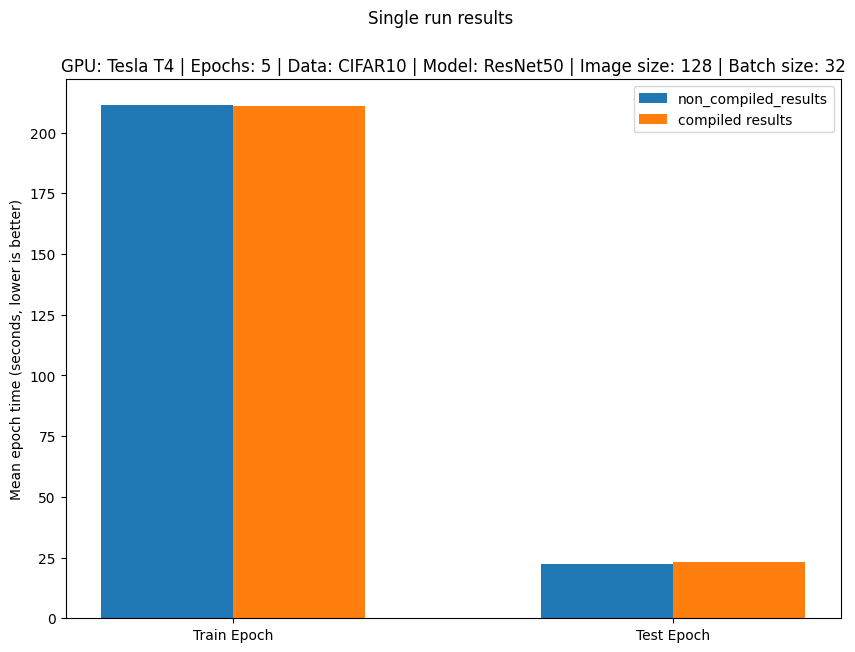

In [31]:
# Create directory for saving figures
import os
dir_to_save_figures_in = "pytorch_2_results/figures/"
os.makedirs(dir_to_save_figures_in, exist_ok=True)

# Create a save path for the single run results
save_path_single_run =  f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_single_run}")

plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df,
                      compiled_results=single_run_compile_results_df,
                      multi_runs=False,
                      save_path=save_path_single_run,
                      save=True)


In [32]:
torch.__version__

'2.1.0+cu121'

In [33]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv


## 4. Time models across multiple runs

* Experiment 3 - 3x5 epochs without `torch.compile()`
* Experiment 4 - 3x5 epochs with `torch.compile()`

Need to create 3 functions

1. **Experiment 3:** `create_and_train_non_compiled_model()`

2. **Experiment 4:** `create_compiled_model()`

3. **Experiment 4:** `train_compiled_model()`

In [34]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        disable_progress_bar=False):
  """
  Create and train a non-compiled PyTorch model
  """

  model, _ = create_model()
  model.to(device)

  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  results = train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  epochs=epochs,
                  device=device,
                  disable_progress_bar=disable_progress_bar)

  return results

In [35]:
def create_compiled_model():
  """
  Create a compiled PyTorch mode and return it
  """

  model, _ = create_model()
  model.to(device)

  compile_start_time = time.time()

  compiled_model = torch.compile(model)

  compile_end_time = time.time()

  compile_time = compile_end_time - compile_start_time

  print(f"[INFO] Model complie time:, {compile_time}")

  return compiled_model

In [36]:
def train_compiled_model(model=compiled_model,
                         epoch=NUM_EPOCHS,
                         learning_rate=LEARNING_RATE,
                         disable_progress_bar=False):
  """
  Train a compiled model and return the results
  """

  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(compiled_model.parameters(), lr=LEARNING_RATE)

  compile_results = train(model=model,
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          epochs=epochs,
                          device=device,
                          disable_progress_bar=disable_progress_bar)

  return compile_results

In [38]:
# Run non-compiled model for multiple runs
NUM_RUNS = 3
NUM_EPOCHS = 5

# Create an empty list to store multiple run results
non_compile_results_multiple_runs = []

# Run non-compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
    results = create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=False)
    non_compile_results_multiple_runs.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for non-compiled model


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0825 | train_acc: 0.6140 | test_loss: 0.7892 | test_acc: 0.7258 | train_epoch_time:211.3939 | test_epoch_time: 22.7948


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6608 | train_acc: 0.7706 | test_loss: 0.6320 | test_acc: 0.7814 | train_epoch_time:210.4679 | test_epoch_time: 22.6499


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.4881 | train_acc: 0.8312 | test_loss: 0.5653 | test_acc: 0.8081 | train_epoch_time:210.6474 | test_epoch_time: 22.8980


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3597 | train_acc: 0.8760 | test_loss: 0.5747 | test_acc: 0.8143 | train_epoch_time:209.7880 | test_epoch_time: 22.4725


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2636 | train_acc: 0.9068 | test_loss: 0.5655 | test_acc: 0.8279 | train_epoch_time:210.7962 | test_epoch_time: 22.9902
[INFO] Run 2 of 3 for non-compiled model


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0540 | train_acc: 0.6257 | test_loss: 0.7707 | test_acc: 0.7332 | train_epoch_time:211.7176 | test_epoch_time: 23.5623


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6295 | train_acc: 0.7821 | test_loss: 0.6398 | test_acc: 0.7764 | train_epoch_time:210.8633 | test_epoch_time: 23.3743


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.4644 | train_acc: 0.8398 | test_loss: 0.5559 | test_acc: 0.8134 | train_epoch_time:210.8918 | test_epoch_time: 23.2569


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3423 | train_acc: 0.8795 | test_loss: 0.5433 | test_acc: 0.8222 | train_epoch_time:211.1269 | test_epoch_time: 23.5673


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2389 | train_acc: 0.9164 | test_loss: 0.5833 | test_acc: 0.8245 | train_epoch_time:211.0753 | test_epoch_time: 23.2600
[INFO] Run 3 of 3 for non-compiled model


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0967 | train_acc: 0.6098 | test_loss: 0.8064 | test_acc: 0.7183 | train_epoch_time:211.7728 | test_epoch_time: 23.5265


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6579 | train_acc: 0.7735 | test_loss: 0.6435 | test_acc: 0.7788 | train_epoch_time:213.5374 | test_epoch_time: 22.3455


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.4833 | train_acc: 0.8333 | test_loss: 0.5364 | test_acc: 0.8189 | train_epoch_time:212.9629 | test_epoch_time: 22.3071


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3553 | train_acc: 0.8764 | test_loss: 0.5914 | test_acc: 0.8189 | train_epoch_time:212.2574 | test_epoch_time: 22.8489


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2518 | train_acc: 0.9114 | test_loss: 0.5889 | test_acc: 0.8275 | train_epoch_time:210.0165 | test_epoch_time: 22.8255


In [42]:
# Go through the non-compile results multiple runs and create a dataframe for each, the combine all into a single dataframe
non_compile_result_dfs = []
for result in non_compile_results_multiple_runs:
  result_df = pd.DataFrame(result)
  non_compile_result_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_result_dfs)

non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()

non_compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.077710,0.616489,0.788746,0.725772,211.628072,23.294494
1,0.649413,0.775379,0.638439,0.778854,211.622880,22.789899
2,0.478638,0.834733,0.552514,0.813465,211.500692,22.820691
3,0.352419,0.877279,0.569830,0.818457,211.057407,22.962887
4,0.251441,0.911535,0.579228,0.826611,210.629329,23.025232


In [ ]:
# Create compiled model
compiled_model = create_compiled_model()

# Create an empty lis to store compiled model result runs
compiled_results_multiple_runs = []

# Run compiled model for multiple training runs
for i in tqdm(range(NUM_RUNS)):
  print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
  # Train compiled model and append results (note: model will only be compiled at the start of the first epoch of the first run)
  results=train_compiled_model(model=compiled_model,
                               epochs=NUM_EPOCHS,
                               disable_progress_bar=False)
  compiled_results_multiple_runs.append(results)

In [ ]:
# Want to combine all the results into a single average dataframe
compile_results_df = []
for result in compiled_results_multiple_runs:
  result_df = pd.DataFrame(result)
  compile_results_df.append(result_df)
compiled_results_multiple_runs_df = pd.concat(compile_results_df)

# Get the average across all the runs for the compiled model
compiled_results_multiple_runs_df = compiled_results_multiple_runs_df.groupby(compiled_results_multiple_runs_df.index).mean()

In [ ]:
# Create a directory to save the multi-run figure to
os.makedirs("pytorch_2_results/figures", exist_ok=True)

# Create a path to save the figure for multiple runs
save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(non_compiled_results=non_compile_results_multiple_runs_df,
                      compiled_results=compiled_results_multiple_runs_df,
                      multi_runs=True,
                      num_runs=NUM_RUNS,
                      save_path=save_path_multi_run,
                      save=True)

In [ ]:
# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

# Save the results
non_compile_results_multiple_runs_df.to_csv(multi_run_no_compile_save_path)
compile_results_multiple_runs_df.to_csv(multi_run_compile_save_path)